In [3]:
%matplotlib inline
# matrix and computational packages
import numpy as np
import theano.tensor as tt
import pymc3 as pm

# visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 500;

<IPython.core.display.Javascript object>

# 1. Model Creation
Models in PyMC3 are centered around the Model contextlib. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a with context:

In [2]:
with pm.Model() as model:
    # Model definition
    pass

Create a simple model to explore the Model class.

In [3]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)  # p ~ N(0, 1)
    obs = pm.Normal('obs', mu=0, sigma=1,  # observed variables
                    observed=np.random.randn(100))

In [4]:
model.basic_RVs

[mu, obs]

In [5]:
model.free_RVs

[mu]

In [6]:
model.observed_RVs

[obs]

In [7]:
model.logp({'mu':0})  # numpy nd.array

array(-146.62619814)

In [21]:
model.logp

**Warning** It’s worth highlighting one of the counter-intuitive design choices with logp. The API makes the logp look like an attribute, when it actually puts together a function based on the current state of the model.

The current design is super maintainable, does terrible if the state stays constant, and great if the state keeps changing, for reasons of design we assume that Model isn’t static, in fact it’s best in our experience and avoids bad results.

If you need to use logp in an inner loop and it needs to be static, simply use something like logp = model.logp below. You can see the caching effect with the speed up below.

In [9]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

44 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.2 µs ± 606 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# 2. Probability Distribution

In the PyMC3 module, the structure for probability distributions looks like this:

[pymc3.distributions]() - [continuous]() - [discrete]() - [timeseries]() - [mixture]()

In [17]:
dir(pm.distributions.mixture)

['Discrete',
 'Distribution',
 'Iterable',
 'Mixture',
 'Normal',
 'NormalMixture',
 '_DrawValuesContext',
 '_DrawValuesContextBlocker',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_conversion_map',
 'all_discrete',
 'bound',
 'broadcast_distribution_samples',
 'draw_values',
 'generate_samples',
 'get_tau_sigma',
 'get_variable_name',
 'logsumexp',
 'np',
 'random_choice',
 'theano',
 'to_tuple',
 'tt']

### Unobserved Random Variables
Every unobserved RV has the following calling signature: name (str), parameter keyword arguments. Thus, a normal prior can be defined in a model context like this:

In [31]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sigma=1)

As with the model, we can evaluate logp

In [34]:
x.logp({'x': 0})

array(-0.91893853)

### Observed Random Variables
Observed RVs are defined just like unobserved RVs but require data to be passed into the observed keyword argument. `observed` argument supports lists, numpy.ndarray, theano and pandas data structures.

In [25]:
with pm.Model():
    obs = pm.Normal('x', mu=0, sigma=1,
                    observed=np.random.randn(100))

### Deterministic Transforms
PyMC3 allows you to freely do algebra with RVs in all kinds of ways:

In [35]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

While these transformations work seamlessly, their results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use `pm.Deterministic`:

In [38]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)
    plus_2 = pm.Deterministic('x plus 2', x + 2)

In [40]:
plus_2

x plus 2

### Automatic transforms of bounded RVs
In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

In [41]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1)

When we look at the RVs of the model, we would expect to find x there, however:

In [43]:
model.free_RVs  # get x_interval__ instead of x

[x_interval__]

In [44]:
model.deterministics  # x is deterministic now

[x]

When displaying results, PyMC3 will usually hide transformed parameters. You can pass the `include_transformed=True` parameter to many functions to see the transformed parameters that are used for sampling.

You can also turn transforms off:

In [46]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)

print(model.free_RVs)

[x]


Or specify different transformation other than the default:

In [47]:
from pymc3.distributions import transforms

with pm.Model() as model:
    x1 = pm.Gamma('x1', alpha=1, beta=1)
    x2 = pm.Gamma('x2', alpha=1, beta=1, transform=transforms.log_exp_m1)
    
print("Default transformation of x1 is %s" % x1.transformation.name)
print("Specified transformation of x2 is %s" % x2.transformation.name)

Default transformation of x1 is log
Specified transformation of x2 is log_exp_m1


In [48]:
model.free_RVs

[x1_log__, x2_log_exp_m1__]

In [49]:
model.deterministics

[x1, x2]

### Transformed distributions and changes of variables
PyMC3 does not provide explicit functionality to transform one distribution to another. Instead, a dedicated distribution is usually created in consideration of optimising performance. However, users can still create transformed distribution by passing the inverse transformation to transform kwarg. Take the classical textbook example of LogNormal: 

${log(y)∼Normal(μ,σ)}$

In [51]:
class Exp(transforms.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)


with pm.Model() as model:
    x1 = pm.Normal('x1', 0., 1., transform=Exp())
    x2 = pm.Lognormal('x2', 0., 1.)

In [53]:
model.free_RVs, model.deterministics

([x1_exp__, x2_log__], [x1, x2])

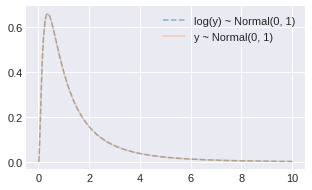

In [54]:
lognorm1 = model.named_vars['x1_exp__']
lognorm2 = model.named_vars['x2']

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0., 10., 1000)

# Plotting
ax.plot(x,
        np.exp(lognorm1.distribution.logp(x).eval()),
        '--',
        alpha=0.5,
        label='log(y) ~ Normal(0, 1)')
ax.plot(x,
        np.exp(lognorm2.distribution.logp(x).eval()),
        alpha=0.3,
        label='y ~ Normal(0, 1)')
plt.legend();

Notice that \${exp(x1)}$ denoted by variable `x1_exp__` is LogNormally distributed 

Using similar approach, we can create ordered RVs following some distribution.

For example, we can combine the ordered transformation and logodds transformation using Chain to create a 2D RV that satisfy \${x1,x2∼Uniform(0,1)}$ and ${x1<x2}$

In [56]:
Order = transforms.Ordered()   # x0 < x1
Logodd = transforms.LogOdds()
chain_tran = transforms.Chain([Logodd, Order])

with pm.Model() as m0:
    x = pm.Uniform(
        'x', 0., 1., shape=2,
        transform=chain_tran,
        testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7187306535600699, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088287655290643, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [57]:
trace.varnames

['x_logodds+ordered__', 'x']

In [58]:
trace['x']

array([[0.94654559, 0.98585651],
       [0.67483932, 0.92535392],
       [0.29443663, 0.5082232 ],
       ...,
       [0.90792492, 0.97242257],
       [0.03775251, 0.07436597],
       [0.8937194 , 0.96816119]])

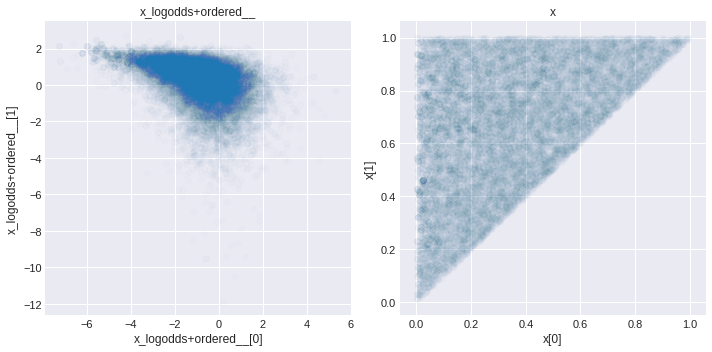

In [59]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:, 0], trace[varname][:, 1], alpha=.01)
    ax[ivar].set_xlabel(varname + '[0]')
    ax[ivar].set_ylabel(varname + '[1]')
    ax[ivar].set_title(varname)
plt.tight_layout()

### Lists of RVs / higher-dimensional RVs
Above we have seen how to create scalar RVs. In many models, you want multiple RVs. There is a tendency (mainly inherited from _PyMC 2.x)_ to create list of RVs, like this:

In [60]:
with pm.Model():
    x = [pm.Normal('x_{}'.format(i), mu=0, sigma=1) for i in range(10)]  # bad

Although the above works, but it's a bad practice as it's slow and not recommended. Instead, use the `shape` kwarg:

In [61]:
with pm.Model():
    X = pm.Normal('X', mu=0, sigma=1, shape=10)  # good practice

_X_ is now a random vector of length 10. We can index into it or do linear algebra operations on it:

In [68]:
with model:
    y = X[0] * X[1] # full indexing is supported
    print("placeholder X0 .* X[1] :", y)
    _S = X.dot(X.T) # Linear algebra is supported
    print("placeholder X X` :", _S)

placeholder X0 .* X[1] : Elemwise{mul,no_inplace}.0
placeholder X X` : dot.0


### Initialization with test_values
While PyMC3 tries to automatically initialize models it is sometimes helpful to define initial values for RVs.

This can be done via the `testval` kwarg:

In [69]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

In [70]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1, shape=5, 
                  testval=np.random.randn(5))  

x.tag.test_value

array([ 0.02053546,  1.02026946, -0.47246765,  0.1677475 , -0.05983873])

This technique is quite useful to identify problems with model specification or initialization.

# 3. Inference
Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: **sampling** and **variational inference**.

### 3.1 Sampling
The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

In [74]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 7170.39draws/s]


As you can see, on a continuous model, PyMC3 assigns the NUTS sampler, which is very efficient even for complex models. PyMC3 also runs variational inference (i.e. ADVI) to find good starting parameters for the sampler. Here we draw 1000 samples from the posterior and allow the sampler to adjust its parameters in an additional 500 iterations. These 500 samples are discarded by default:

In [75]:
len(trace)

1000

In [76]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.rand(100))\
    
    trace = pm.sample(1000, tune=500)  # NUTS sampler on 1000 samples + 500 additional iterations

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 8111.39draws/s]
The acceptance probability does not match the target. It is 0.8797133547503306, but should be close to 0.8. Try to increase the number of tuning steps.


In [79]:
trace['mu'].shape

(4000,)

In [78]:
trace.nchains

4

In [77]:
trace.get_values('mu', chains=1).shape # get values of a single chain

(1000,)

In [80]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SMC',
 'Slice']

Commonly used step-methods besides NUTS are Metropolis and Slice. 

**For almost all continuous models, ``NUTS`` should be preferred.** There are hard-to-sample models for which NUTS will be very slow causing many users to use Metropolis instead. This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex or it is badly initialized. In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample size or not converge properly at all. A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.

For completeness, other sampling methods can be passed to sample:

In [81]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 13507.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


You can also assign variables to different step methods.

In [5]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace = pm.sample(10000, step=[step1, step2], cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 8353.76draws/s]
The number of effective samples is smaller than 25% for some parameters.


## 3.2 Analyze sampling results

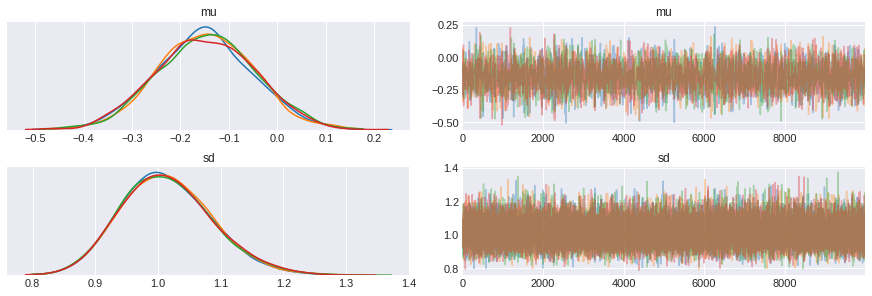

In [7]:
pm.traceplot(trace);

Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic:

In [9]:
pm.gelman_rubin(trace)

{'mu': 1.0004067391758595, 'sd': 1.0000177564102644}

These are also part of the forestplot:

/home/sliu/Devel/pyenvs/pymc3/lib/python3.6/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/sliu/Devel/pyenvs/pymc3/lib/python3.6/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


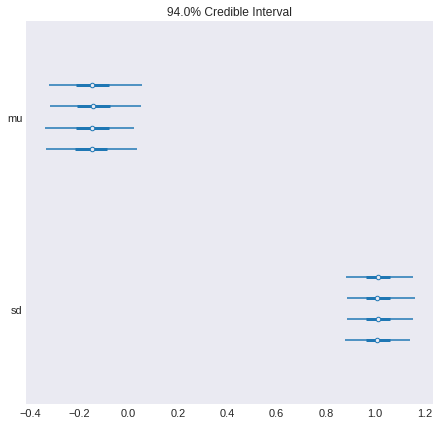

In [10]:
pm.forestplot(trace);

Finally, for a plot of the posterior that is inspired by the book Doing Bayesian Data Analysis, you can use the:

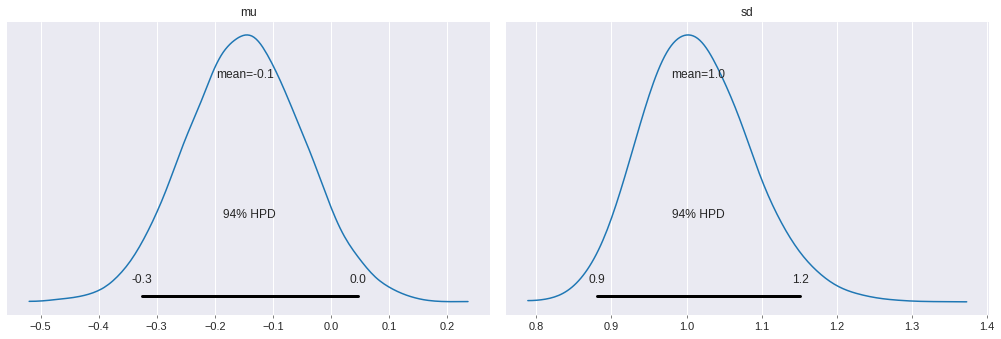

In [11]:
pm.plot_posterior(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2400.60draws/s]


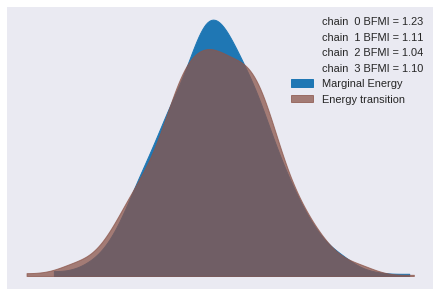

In [12]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sigma=1, shape=100)
    trace = pm.sample(cores=4)

pm.energyplot(trace);

For more information on sampler stats and the energy plot, see here. For more information on identifying sampling problems and what to do about them, see here.

## 3.3 Variational inference
PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc3.fit()`.